In [1]:
import os #
import boto3 #
import matplotlib.pyplot as plt #
import pandas as pd #
from dotenv import load_dotenv #
from pycaret.regression import compare_models, plot_model, save_model, setup #

In [2]:
load_dotenv()

True

## Digital Ocean Spaces

In [3]:
s3 = boto3.client("s3")

In [4]:
BUCKET_NAME="kursjustyna"

In [5]:
# wysyłam pliki do Cloud Storage
folder_path = "C:\\Users\\jmkko\\OneDrive\\Pulpit\\od_zera_do_ai\\modul_9\\41_zadanie\\dane"

# Looping through the files in the folder and uploading them to the S3 bucket
for file_name in os.listdir(folder_path):
    file_path = os.path.join(folder_path, file_name)
    
    # Uploading file to the S3 bucket
    with open(file_path, "rb") as data:
        s3.upload_fileobj(data, BUCKET_NAME, file_name)

In [6]:
# Tworzę df na podstawie 2 plików csv
response = s3.list_objects(Bucket=BUCKET_NAME)
all_files = [content['Key'] for content in response['Contents']]

dfs = []  # Lista do przechowywania dataframe'ów

for file in all_files:
    obj = s3.get_object(Bucket=BUCKET_NAME, Key=file)
    df_f = pd.read_csv(obj['Body'], sep=';')  # 'Body' is a key word

    # Uzupełnianie kolumny "Rok" na podstawie nazwy pliku
    if "2023" in file:
        df_f['Rok'] = 2023
    elif "2024" in file:
        df_f['Rok'] = 2024
    else:
        df_f['Rok'] = None  # lub inna wartość domyślna, jeśli nie pasuje

    # Zastąp wartości NaN w "Rocznik" wartością z "Rok"
    df_f['Rocznik'] = df_f['Rocznik'].fillna(df_f['Rok'])
    
    # Konwersja kolumny "Rok" do typu Int64
    df_f['Rok'] = df_f['Rok'].astype('Int64')  # Używamy 'Int64' aby obsługiwać typ nullable

    # Konwersja kolumny "Rocznik" do Int64 (upewnij się, że pierwotnie jest w poprawnym formacie)
    df_f['Rocznik'] = df_f['Rocznik'].astype('Int64')  # Używamy 'Int64' aby obsługiwać typ nullable

    # Zastąp wartości NaN w "Rocznik" wartością z "Rok"
    df_f['Rocznik'] = df_f['Rocznik'].fillna(df_f['Rok'])

    # Obliczanie wieku jako różnicy między Rokiem a Rocznikiem
    df_f['Wiek'] = df_f['Rok'] - df_f['Rocznik']

    dfs.append(df_f)

df = pd.concat(dfs, ignore_index=True)
df.head()

,Miejsce,Numer startowy,Imię,Nazwisko,Miasto,Kraj,Drużyna,Płeć,Płeć Miejsce,Kategoria wiekowa,...,15 km Miejsce Open,15 km Tempo,20 km Czas,20 km Miejsce Open,20 km Tempo,Tempo Stabilność,Czas,Tempo,Rok,Wiek
0,1.0,1787,TOMASZ,GRYCKO,NaN,POL,UKS BLIZA WŁADYSŁAWOWO,M,1.0,M30,...,1.0,3.106667,01:01:43,1.0,3.386667,0.031400,01:04:59,3.080509,2023,31
1,2.0,3,ARKADIUSZ,GARDZIELEWSKI,WROCŁAW,POL,ARKADIUSZGARDZIELEWSKI.PL,M,2.0,M30,...,2.0,3.143333,01:03:08,2.0,3.540000,0.038000,01:06:23,3.146875,2023,37
2,3.0,3832,KRZYSZTOF,HADAS,POZNAŃ,POL,NaN,M,3.0,M20,...,3.0,3.236667,01:05:09,3.0,3.516667,0.024067,01:08:24,3.242475,2023,27
3,4.0,416,DAMIAN,DYDUCH,KĘPNO,POL,AZS POLITECHNIKA OPOLSKA,M,4.0,M30,...,5.0,3.330000,01:06:54,4.0,3.616667,0.025467,01:10:16,3.330963,2023,35
4,5.0,8476,KAMIL,MAŃKOWSKI,MIRKÓW,POL,PARKRUN WROCŁAW,M,5.0,M20,...,7.0,3.386667,01:07:27,5.0,3.586667,0.023000,01:10:27,3.339654,2023,28


In [7]:
# pozbywam się zbędnych kolumn (część jest zbędna, przez niektóre model był "przetrenowany")
df = df[["Płeć", "Wiek", "5 km Czas", "Czas"]]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21957 entries, 0 to 21956
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Płeć       21946 non-null  object
 1   Wiek       21957 non-null  Int64 
 2   5 km Czas  18411 non-null  object
 3   Czas       19902 non-null  object
dtypes: Int64(1), object(3)
memory usage: 707.7+ KB


In [8]:
brakujące_rzędy_df = df.isnull().sum()

braki_procent_df = (brakujące_rzędy_df / len(df)) * 100

podsumowanie_braków_df = pd.DataFrame({
    'brakujące rzędy': brakujące_rzędy_df,
    'braki wyrażone w procentach': braki_procent_df
})

result = {
    "type": "dataframe",
    "value": podsumowanie_braków_df
}
podsumowanie_braków_df

,brakujące rzędy,braki wyrażone w procentach
Płeć,11,0.050098
Wiek,0,0.000000
5 km Czas,3546,16.149747
Czas,2055,9.359202


In [9]:
# usuwam wiersze z brakami
df_clean = df.dropna()
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18411 entries, 0 to 19249
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Płeć       18411 non-null  object
 1   Wiek       18411 non-null  Int64 
 2   5 km Czas  18411 non-null  object
 3   Czas       18411 non-null  object
dtypes: Int64(1), object(3)
memory usage: 737.2+ KB


In [10]:
# trzeba zmienić Dtype w "5 km czas" i "Czas" na int64
def convert_time_to_seconds(time):
    if pd.isnull(time) or time in ['DNS', 'DNF']:
        return None
    time = time.split(':')
    return int(time[0]) * 3600 + int(time[1]) * 60 + int(time[2])
df_clean['5 km Czas'] = df_clean['5 km Czas'].apply(convert_time_to_seconds)
df_clean['5 km Czas'].head()

0    877
1    888
2    946
3    971
4    972
Name: 5 km Czas, dtype: int64

In [11]:
df_clean['Czas'] = df_clean['Czas'].apply(convert_time_to_seconds)
df_clean['Czas'].head()

0    3899
1    3983
2    4104
3    4216
4    4227
Name: Czas, dtype: int64

In [12]:
# pozbywam się wartości odstających w kluczowych kolumnach 
columns = ["Czas", "5 km Czas", "Wiek"]

for column in columns:
    # Obliczam kwantyle dla określonej kolumny
    Q1 = df_clean[column].quantile(0.25)
    Q3 = df_clean[column].quantile(0.75)
    IQR = Q3 - Q1  # różnica między kwartylami

    # Obliczam granice dla wykrywania outlierów
    lower_bound = Q1 - 1.5 * IQR  # inteligentne minimum
    upper_bound = Q3 + 1.5 * IQR  # inteligentne maksimum

    # Usuwam outlierów
    df_clean = df_clean[~((df_clean[column] < lower_bound) | (df_clean[column] > upper_bound))]
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17449 entries, 8 to 19114
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Płeć       17449 non-null  object
 1   Wiek       17449 non-null  Int64 
 2   5 km Czas  17449 non-null  int64 
 3   Czas       17449 non-null  int64 
dtypes: Int64(1), int64(2), object(1)
memory usage: 698.6+ KB


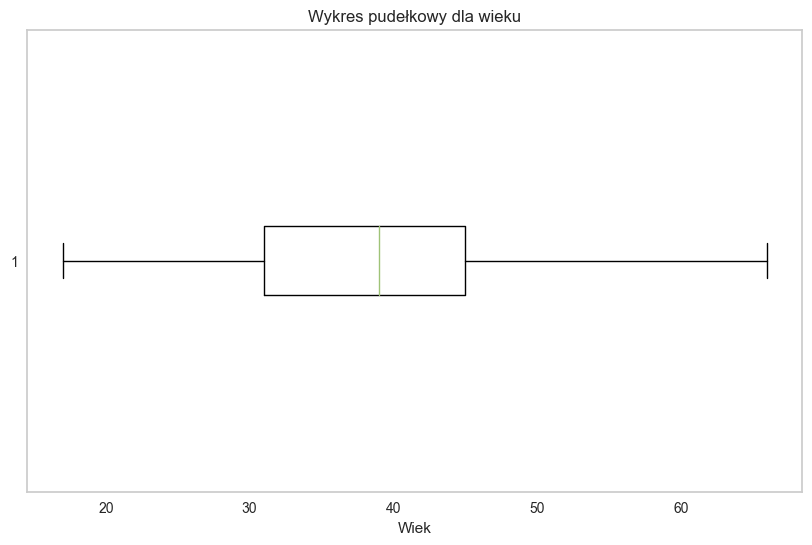

In [13]:
plt.figure(figsize=(10, 6))
plt.boxplot(df_clean['Wiek'], vert=False)
plt.title('Wykres pudełkowy dla wieku')
plt.xlabel('Wiek')
plt.grid()
plt.show()

In [14]:
# proszę Pacaret o pomoc w obliczeniach :)
exp = setup(data=df_clean, target='Czas', session_id=123)

,Description,Value
0,Session id,123
1,Target,Czas
2,Target type,Regression
3,Original data shape,"(17449, 4)"
4,Transformed data shape,"(17449, 4)"
5,Transformed train set shape,"(12214, 4)"
6,Transformed test set shape,"(5235, 4)"
7,Numeric features,2
8,Categorical features,1
9,Preprocess,True


In [15]:
best_model = exp.compare_models(sort="R2")
print("Najlepszy model:", best_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,291.6364,157274.6637,396.4019,0.8780,0.0510,0.0385,0.3550
lasso,Lasso Regression,291.6039,157280.3757,396.4090,0.8780,0.0510,0.0385,0.2280
ridge,Ridge Regression,291.6363,157274.6496,396.4019,0.8780,0.0510,0.0385,0.0090
en,Elastic Net,291.5662,157273.1417,396.4000,0.8780,0.0510,0.0385,0.0090
lar,Least Angle Regression,291.6364,157274.6637,396.4019,0.8780,0.0510,0.0385,0.0100
llar,Lasso Least Angle Regression,291.6039,157280.3757,396.4090,0.8780,0.0510,0.0385,0.0090
omp,Orthogonal Matching Pursuit,291.6205,157355.7625,396.5035,0.8780,0.0510,0.0385,0.0090
br,Bayesian Ridge,291.5609,157273.8459,396.4009,0.8780,0.0510,0.0385,0.0090
gbr,Gradient Boosting Regressor,291.4221,157474.6892,396.6503,0.8779,0.0510,0.0385,0.0510
lightgbm,Light Gradient Boosting Machine,293.4274,160224.5722,400.1108,0.8757,0.0515,0.0388,0.0750


Processing:   0%|          | 0/77 [00:00<?, ?it/s]

Najlepszy model: LinearRegression(n_jobs=-1)


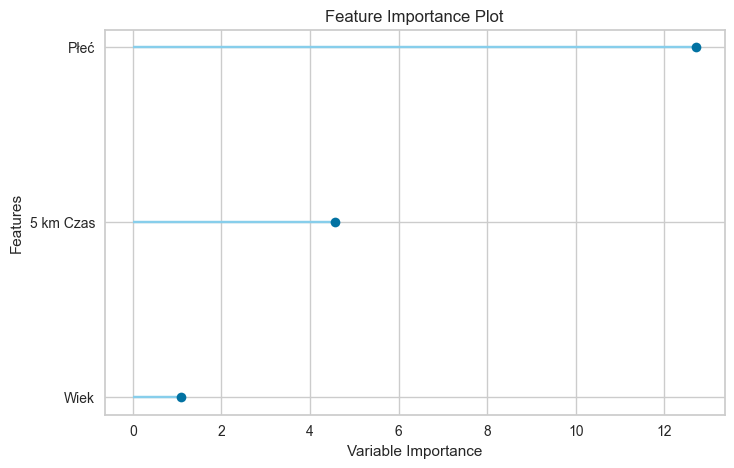

In [16]:
plot_model(best_model, plot='feature')

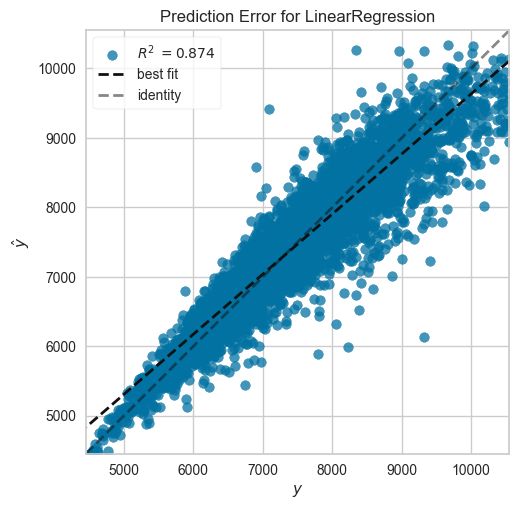

In [17]:
exp.plot_model(best_model, plot='error')

In [18]:
# zapisuję model u siebie na dysku
save_model(best_model, 'halfmarathon_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['Wiek', '5 km Czas'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=['Płeć'],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('ordinal_encoding',
                  TransformerWrapper(include=['Płeć'],
                                     transformer=OrdinalEncoder(cols=['Płeć'],
                                                                handle_missing='return_nan',
                                                                mapping=[{'col': 'Płeć',
                                                                          'data_type': dtype('O'),
                                                                          'mapping': K      0
 M      1
 NaN   -1
 dtype: int64}]))),
          

In [19]:
# wrzucam model do Cloud Storage
s3.upload_file('halfmarathon_model.pkl', BUCKET_NAME, 'halfmarathon_model.pkl')